# Bollinger bands strategy

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
ticker = 'EURUSD=X'
start = '2019-10-10'
end = '2023-10-10'
interval = '1d'
df = yf.download(ticker, start=start, end=end, interval=interval)['Adj Close'].to_frame()

[*********************100%%**********************]  1 of 1 completed


In [3]:
window = 30
dev = 2

In [4]:
df['SMA'] = df['Adj Close'].rolling(window).mean()
df['devstd'] = df['Adj Close'].rolling(window).std()
df['lowerBoll'] = df['SMA'] - dev * df['devstd']
df['upperBoll'] = df['SMA'] + dev * df['devstd']

In [5]:
df.dropna(inplace=True)

<Axes: xlabel='Date'>

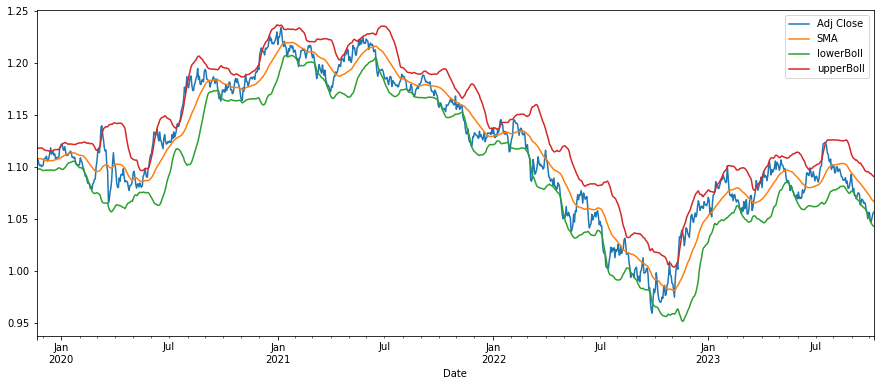

In [6]:
df[['Adj Close','SMA', 'lowerBoll', 'upperBoll']].plot(figsize=(15,6))

In [7]:
# If the price go under the lower band, we take a long position
df['position'] = np.where(df['Adj Close']<df.lowerBoll, 1, np.nan)
# If the price go over the upper band, we take a short position
df['position'] = np.where(df['Adj Close']>df.upperBoll, -1, df['position'])

# If the asset price change and goes under or upper the SMA (compared to the day before)
# we take a neutral position (0), otherwise we stay with the old position value
df['position'] = np.where(np.sign(df['Adj Close']-df.SMA) #+1 if the price is greater than the SMA, -1 otherwise
                          !=
                          np.sign(df['Adj Close']-df.SMA).shift(1),
                          0, df.position)

In [8]:
df['position'].loc['2021-08']

Date
2021-08-02    NaN
2021-08-03    NaN
2021-08-04    NaN
2021-08-05    0.0
2021-08-06    NaN
2021-08-09    NaN
2021-08-10    1.0
2021-08-11    1.0
2021-08-12    NaN
2021-08-13    NaN
2021-08-16    NaN
2021-08-17    NaN
2021-08-18    NaN
2021-08-19    NaN
2021-08-20    1.0
2021-08-23    NaN
2021-08-24    NaN
2021-08-25    NaN
2021-08-26    NaN
2021-08-27    NaN
2021-08-30    0.0
2021-08-31    NaN
Name: position, dtype: float64

We can see that on '2021-08-10' we have a +1, this means that the price went under the lower bound. On '2021-08-30' instead we have a 0, it means that the price crossed the moving average. With this trading strategy we take a short position when we have +1 and we keep with the short position till the 0. So we care about the first +1 (or -1) occurrence that indicate to take a long (or short) position, and the 0 that is for the selling point. In order to clear the dataset from the nan, we do a *forward fill* with the previous value, because when we take a position we keep that position till we ecounter a zero:

In [9]:
df['position'] = df['position'].ffill()

<Axes: xlabel='Date'>

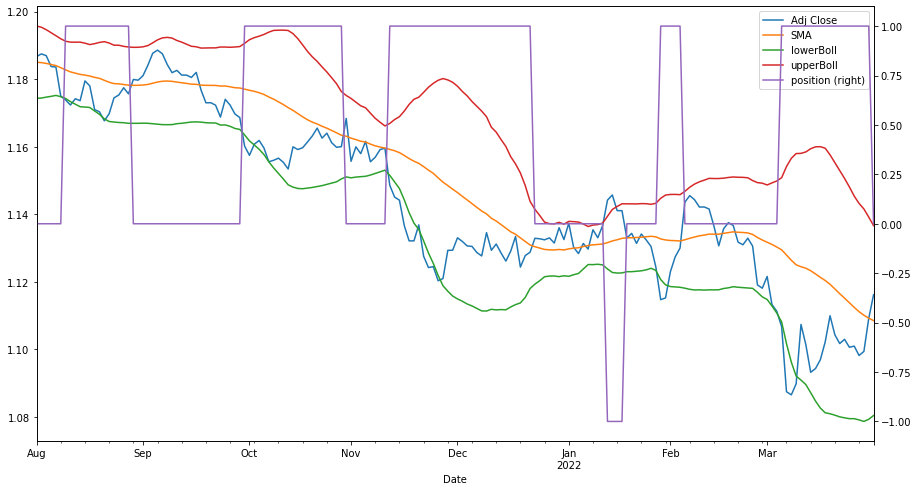

In [10]:
df[['Adj Close','SMA', 'lowerBoll', 'upperBoll', 'position']].loc['2021-08':'2022-03'].plot(figsize=(15,8),
                                                                                  secondary_y='position')

# Backtesting

In [11]:
df['logRet'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))

In [12]:
df['strategy'] = df.position.shift(1) * df.logRet

In [13]:
# Total return of our strategy (-0.38%, good...)
df.strategy.sum()

-0.003835960977086453

In [14]:
# Total return of buy&hold
df.logRet.sum()

-0.04736111022247302

<Axes: xlabel='Date'>

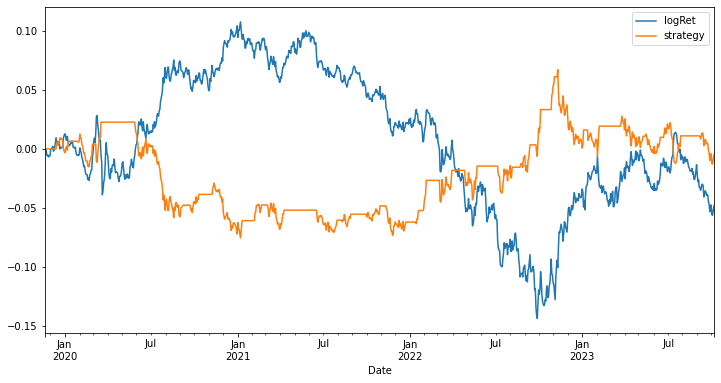

In [15]:
df[['logRet','strategy']].cumsum().plot(figsize=(12,6))

Now we introduce costs due to the commissions (we talked about it in the [previous notebook](https://github.com/alecontuIT/algo_trading_coletti/blob/main/6_Momentum_contrarian_strategies.ipynb). But in this case, we pay just half spread, beacause we don't switch from a long to a short position (or viceversa) but from a long to a neutral or from a short to a neutral position. 

In [31]:
comm = 0.0001
spread = 0.00008/df['Adj Close'].mean()

In [32]:
# We have 0 if we don't change position, +1 if we changed 
df['transactions'] = abs(df.position.shift(1) - df.position.shift(2))

In [33]:
# We compute the net return, so we subtract the transactions costs
df['netStrategy'] = df['strategy'] - df.transactions*(comm + spread/2)

<Axes: xlabel='Date'>

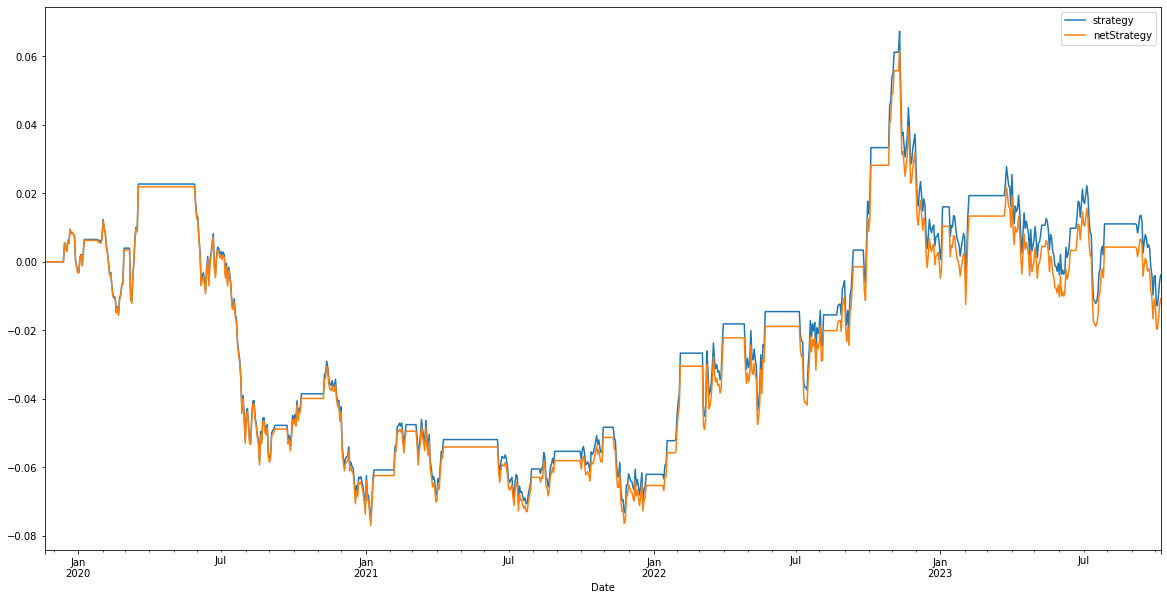

In [34]:
df[['strategy', 'netStrategy']].cumsum().plot(figsize=(20,10))

In [36]:
# Annual mean return:
# we traded 4 years (2019-2023)
# each year has 251 tradable days
df[['strategy', 'netStrategy']].mean()*4*251

strategy      -0.003802
netStrategy   -0.010677
dtype: float64

<Axes: xlabel='Date'>

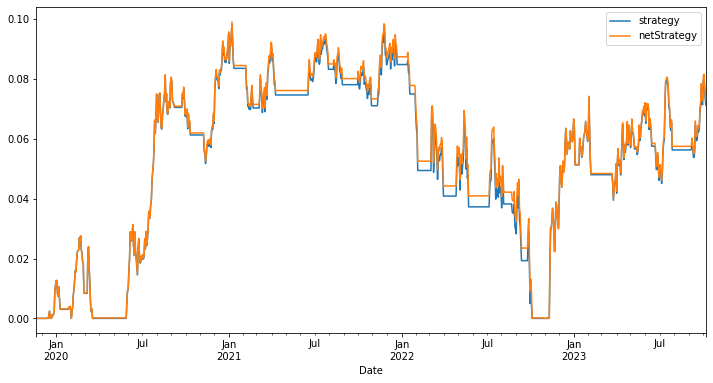

In [39]:
# Drawdown
(df[['strategy', 'netStrategy']].cumsum().cummax() - df[['strategy', 'netStrategy']].cumsum()).plot(figsize=(12,6))

# Parameters optimization